In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import boxcox
import nltk
from transformers import pipeline
from tqdm.auto import tqdm
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

2025-11-01 17:22:37.197951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762017757.358347      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762017757.406886      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dfa_jan1 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesJan2017.csv")
dfa_jan2 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesJan2018.csv")
dfa_feb1 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesFeb2017.csv")
dfa_feb2 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesFeb2018.csv")
dfa_mar1 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesMarch2017.csv")
dfa_mar2 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesMarch2018.csv")
dfa_apr1 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesApril2017.csv")
dfa_apr2 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesApril2018.csv")
dfa_may1 = pd.read_csv("/kaggle/input/nyt-comments/ArticlesMay2017.csv")

dfc_jan1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsJan2017.csv")
dfc_jan2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsJan2018.csv")
dfc_feb1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsFeb2017.csv")
dfc_feb2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsFeb2018.csv")
dfc_mar1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsMarch2017.csv")
dfc_mar2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsMarch2018.csv")
dfc_apr1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsApril2017.csv")
dfc_apr2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsApril2018.csv")
dfc_may1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsMay2017.csv")

/tmp/ipykernel_37/1978054138.py:11: DtypeWarning: Columns (14,15,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc_jan1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsJan2017.csv")
/tmp/ipykernel_37/1978054138.py:12: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc_jan2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsJan2018.csv")
/tmp/ipykernel_37/1978054138.py:13: DtypeWarning: Columns (14,15,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc_feb1 = pd.read_csv("/kaggle/input/nyt-comments/CommentsFeb2017.csv")
/tmp/ipykernel_37/1978054138.py:14: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  dfc_feb2 = pd.read_csv("/kaggle/input/nyt-comments/CommentsFeb2018.csv")
/tmp/ipykernel_37/1978054138.py:15: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=F

In [3]:
dfa_jan1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   articleID         850 non-null    object
 1   abstract          40 non-null     object
 2   byline            850 non-null    object
 3   documentType      850 non-null    object
 4   headline          850 non-null    object
 5   keywords          850 non-null    object
 6   multimedia        850 non-null    int64 
 7   newDesk           850 non-null    object
 8   printPage         850 non-null    int64 
 9   pubDate           850 non-null    object
 10  sectionName       850 non-null    object
 11  snippet           850 non-null    object
 12  source            850 non-null    object
 13  typeOfMaterial    850 non-null    object
 14  webURL            850 non-null    object
 15  articleWordCount  850 non-null    int64 
dtypes: int64(3), object(13)
memory usage: 106.4+ KB


In [4]:
dfc_jan1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231449 entries, 0 to 231448
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   approveDate            231449 non-null  int64  
 1   articleID              231449 non-null  object 
 2   articleWordCount       231449 non-null  int64  
 3   commentBody            231449 non-null  object 
 4   commentID              231449 non-null  float64
 5   commentSequence        231449 non-null  float64
 6   commentTitle           218042 non-null  object 
 7   commentType            231449 non-null  object 
 8   createDate             231449 non-null  int64  
 9   depth                  231449 non-null  float64
 10  editorsSelection       231449 non-null  int64  
 11  inReplyTo              231449 non-null  int64  
 12  newDesk                231449 non-null  object 
 13  parentID               231449 non-null  float64
 14  parentUserDisplayName  56226 non-nul

In [5]:
df_jan1 = dfa_jan1.merge(dfc_jan1, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_jan2 = dfa_jan2.merge(dfc_jan2, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_feb1 = dfa_feb1.merge(dfc_feb1, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_feb2 = dfa_feb2.merge(dfc_feb2, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_mar1 = dfa_mar1.merge(dfc_mar1, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_mar2 = dfa_mar2.merge(dfc_mar2, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_apr1 = dfa_apr1.merge(dfc_apr1, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_apr2 = dfa_apr2.merge(dfc_apr2, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')
df_may1 = dfa_may1.merge(dfc_may1, on = ['articleID', 'newDesk', 'printPage', 'sectionName', 'typeOfMaterial', 'articleWordCount'], how = 'inner')

In [7]:
df_jan1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231449 entries, 0 to 231448
Data columns (total 44 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   articleID              231449 non-null  object 
 1   abstract               4474 non-null    object 
 2   byline                 231449 non-null  object 
 3   documentType           231449 non-null  object 
 4   headline               231449 non-null  object 
 5   keywords               231449 non-null  object 
 6   multimedia             231449 non-null  int64  
 7   newDesk                231449 non-null  object 
 8   printPage              231449 non-null  int64  
 9   pubDate                231449 non-null  object 
 10  sectionName            231449 non-null  object 
 11  snippet                231449 non-null  object 
 12  source                 231449 non-null  object 
 13  typeOfMaterial         231449 non-null  object 
 14  webURL                 231449 non-nu

In [8]:
datalist = [df_jan1, df_jan2, df_feb1, df_feb2, df_mar1, df_mar2, df_apr1, df_apr2, df_may1]

In [9]:
df = pd.concat(datalist, ignore_index = True)

In [17]:
df["commentTitle"].unique()

array(['<br/>', nan], dtype=object)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991146 entries, 0 to 1991145
Data columns (total 44 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   articleID              object 
 1   abstract               object 
 2   byline                 object 
 3   documentType           object 
 4   headline               object 
 5   keywords               object 
 6   multimedia             int64  
 7   newDesk                object 
 8   printPage              int64  
 9   pubDate                object 
 10  sectionName            object 
 11  snippet                object 
 12  source                 object 
 13  typeOfMaterial         object 
 14  webURL                 object 
 15  articleWordCount       int64  
 16  approveDate            int64  
 17  commentBody            object 
 18  commentID              float64
 19  commentSequence        float64
 20  commentTitle           object 
 21  commentType            object 
 22  createDate        

In [10]:
#df.to_csv("nyt_merged.csv", index = False)

In [11]:
df.isnull().sum()

articleID                      0
abstract                 1980529
byline                         0
documentType                   0
headline                       0
keywords                       0
multimedia                     0
newDesk                        0
printPage                      0
pubDate                        0
sectionName                    0
snippet                        0
source                         0
typeOfMaterial                 0
webURL                         0
articleWordCount               0
approveDate                    0
commentBody                    1
commentID                      0
commentSequence                0
commentTitle               76721
commentType                    0
createDate                     0
depth                          0
editorsSelection               0
inReplyTo                      0
parentID                       0
parentUserDisplayName    1453931
permID                        20
picURL                         0
recommenda

In [6]:
df.drop(['abstract', 'parentUserDisplayName', 'recommendedFlag', 'reportAbuseFlag', 'userTitle', 'userURL'], axis = 1, inplace = True)

In [7]:
df.dropna(inplace = True)

In [14]:
df.isnull().sum()

articleID           0
byline              0
documentType        0
headline            0
keywords            0
multimedia          0
newDesk             0
printPage           0
pubDate             0
sectionName         0
snippet             0
source              0
typeOfMaterial      0
webURL              0
articleWordCount    0
approveDate         0
commentBody         0
commentID           0
commentSequence     0
commentTitle        0
commentType         0
createDate          0
depth               0
editorsSelection    0
inReplyTo           0
parentID            0
permID              0
picURL              0
recommendations     0
replyCount          0
sharing             0
status              0
timespeople         0
trusted             0
updateDate          0
userDisplayName     0
userID              0
userLocation        0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913734 entries, 0 to 1991145
Data columns (total 38 columns):
 #   Column            Dtype  
---  ------            -----  
 0   articleID         object 
 1   byline            object 
 2   documentType      object 
 3   headline          object 
 4   keywords          object 
 5   multimedia        int64  
 6   newDesk           object 
 7   printPage         int64  
 8   pubDate           object 
 9   sectionName       object 
 10  snippet           object 
 11  source            object 
 12  typeOfMaterial    object 
 13  webURL            object 
 14  articleWordCount  int64  
 15  approveDate       int64  
 16  commentBody       object 
 17  commentID         float64
 18  commentSequence   float64
 19  commentTitle      object 
 20  commentType       object 
 21  createDate        float64
 22  depth             float64
 23  editorsSelection  int64  
 24  inReplyTo         float64
 25  parentID          float64
 26  permID            o

In [8]:
df['createDate'] = pd.to_datetime(df['createDate'], unit='s')

In [9]:
df['year'] = df['createDate'].dt.year
df['month'] = df['createDate'].dt.month
df['day'] = df['createDate'].dt.day
df['hour'] = df['createDate'].dt.hour
df['dayofweek'] = df['createDate'].dt.dayofweek

df['is_weekend'] = df['dayofweek'].isin([5, 6])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913734 entries, 0 to 1991145
Data columns (total 44 columns):
 #   Column            Dtype         
---  ------            -----         
 0   articleID         object        
 1   byline            object        
 2   documentType      object        
 3   headline          object        
 4   keywords          object        
 5   multimedia        int64         
 6   newDesk           object        
 7   printPage         int64         
 8   pubDate           object        
 9   sectionName       object        
 10  snippet           object        
 11  source            object        
 12  typeOfMaterial    object        
 13  webURL            object        
 14  articleWordCount  int64         
 15  approveDate       int64         
 16  commentBody       object        
 17  commentID         float64       
 18  commentSequence   float64       
 19  commentTitle      object        
 20  commentType       object        
 21  createDate   

In [10]:
df['depth'] = df['depth'].astype(np.int32)

In [11]:
df['replyCount'].unique()

array([   0.,    1.,    2.,    3.,    6.,    4.,    7.,    5.,    8.,
         26.,   10.,   12.,    9.,   11.,   13.,   36.,   24.,   20.,
         56.,   15.,   14.,   17.,   16.,   23.,   25.,   21.,   40.,
         51.,   33.,   28.,   32.,   27.,   39.,   18.,   19.,   50.,
         46.,   43.,   86.,   29.,   58.,   22.,   45.,   38.,   68.,
         55.,   90.,   65.,   30.,   48.,   54.,   35.,  155.,   63.,
         47.,   59.,  277.,   34.,   37.,   31.,  101.,   53.,  148.,
         57.,   42.,  121.,  117.,   77.,   73.,   79.,  113.,   84.,
        190.,   74.,   41.,   64.,   44.,  157.,  203.,   61.,   52.,
         83.,  186.,  138.,   82.,  239.,   70.,  227.,  461.,   92.,
        529.,   76.,   67.,   49.,   66.,  107.,  417.,  111.,   60.,
         99.,  179.,  199.,   87.,   97.,  110.,   96.,   98.,  145.,
         95.,   88.,   71.,  168.,   72.,   89.,  116.,  196.,   94.,
        122.,   91.,  147.,  142.,  106.,  150.,  187.,  129.,  238.,
        161.,  120.,

In [12]:
df = df[df['replyCount'] >= 0]

In [13]:
df =  df.drop(columns = ['source' , 'webURL', 'commentSequence' , 'approveDate' , 'createDate' , 'permID' , 'picURL' , 'status' , 'userDisplayName' , 'updateDate' , 'userLocation'], axis = 1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913721 entries, 0 to 1991145
Data columns (total 33 columns):
 #   Column            Dtype  
---  ------            -----  
 0   articleID         object 
 1   byline            object 
 2   documentType      object 
 3   headline          object 
 4   keywords          object 
 5   multimedia        int64  
 6   newDesk           object 
 7   printPage         int64  
 8   pubDate           object 
 9   sectionName       object 
 10  snippet           object 
 11  typeOfMaterial    object 
 12  articleWordCount  int64  
 13  commentBody       object 
 14  commentID         float64
 15  commentTitle      object 
 16  commentType       object 
 17  depth             int32  
 18  editorsSelection  int64  
 19  inReplyTo         float64
 20  parentID          float64
 21  recommendations   float64
 22  replyCount        float64
 23  sharing           int64  
 24  timespeople       float64
 25  trusted           float64
 26  userID            f

In [14]:
df['pubDate'] = pd.to_datetime(df['pubDate'])   
df['Publish_Day'] = df['pubDate'].dt.day  
df['Publish_Month'] = df['pubDate'].dt.month
df['Publish_Year'] = df['pubDate'].dt.year
df['Publish_Dayofweek'] = df['pubDate'].dt.dayofweek
df['Publish_IsWeekend'] = df['Publish_Dayofweek'].isin([5,6])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913721 entries, 0 to 1991145
Data columns (total 38 columns):
 #   Column             Dtype         
---  ------             -----         
 0   articleID          object        
 1   byline             object        
 2   documentType       object        
 3   headline           object        
 4   keywords           object        
 5   multimedia         int64         
 6   newDesk            object        
 7   printPage          int64         
 8   pubDate            datetime64[ns]
 9   sectionName        object        
 10  snippet            object        
 11  typeOfMaterial     object        
 12  articleWordCount   int64         
 13  commentBody        object        
 14  commentID          float64       
 15  commentTitle       object        
 16  commentType        object        
 17  depth              int32         
 18  editorsSelection   int64         
 19  inReplyTo          float64       
 20  parentID           float64   

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


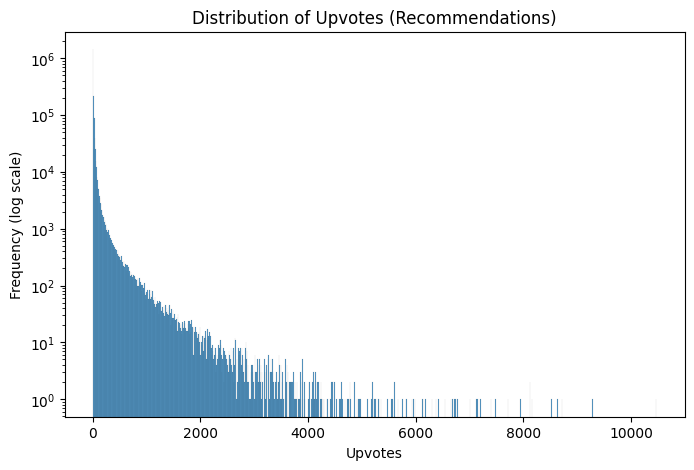

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['recommendations'], bins=1000, log_scale=(False, True))  # log y-axis since it's skewed
plt.title("Distribution of Upvotes (Recommendations)")
plt.xlabel("Upvotes")
plt.ylabel("Frequency (log scale)")
plt.show()

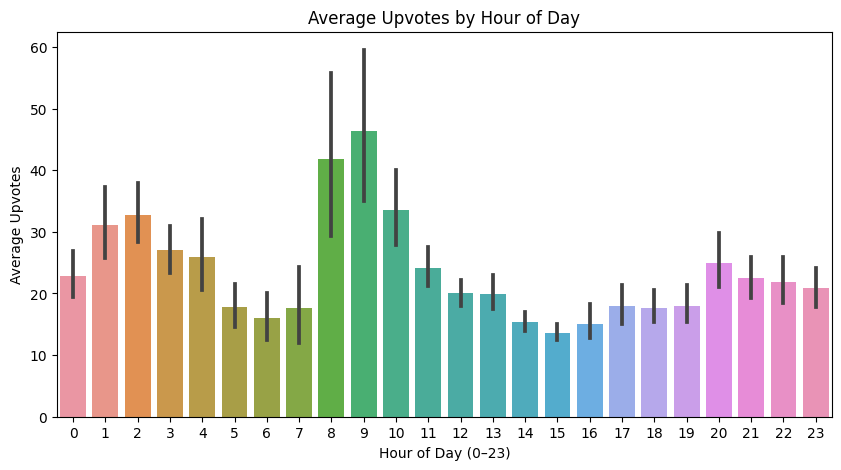

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(
    x="hour", 
    y="recommendations", 
    data=df.sample(100000, random_state=42)  # sample for speed
)
plt.title("Average Upvotes by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Upvotes")
plt.show()

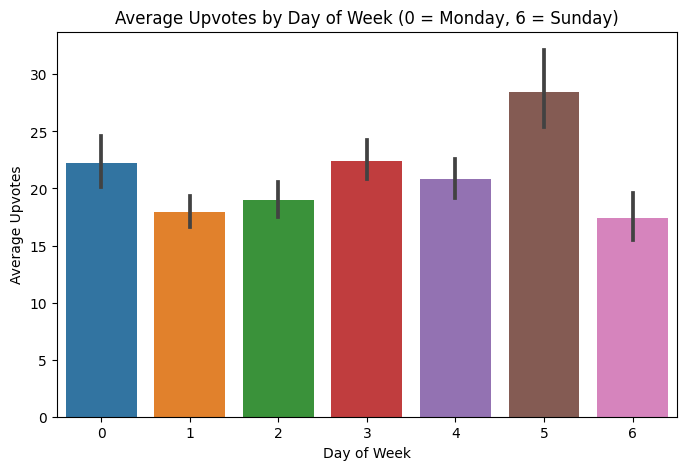

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="dayofweek", 
    y="recommendations", 
    data=df.sample(100000, random_state=42)
)
plt.title("Average Upvotes by Day of Week (0 = Monday, 6 = Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Average Upvotes")
plt.show()

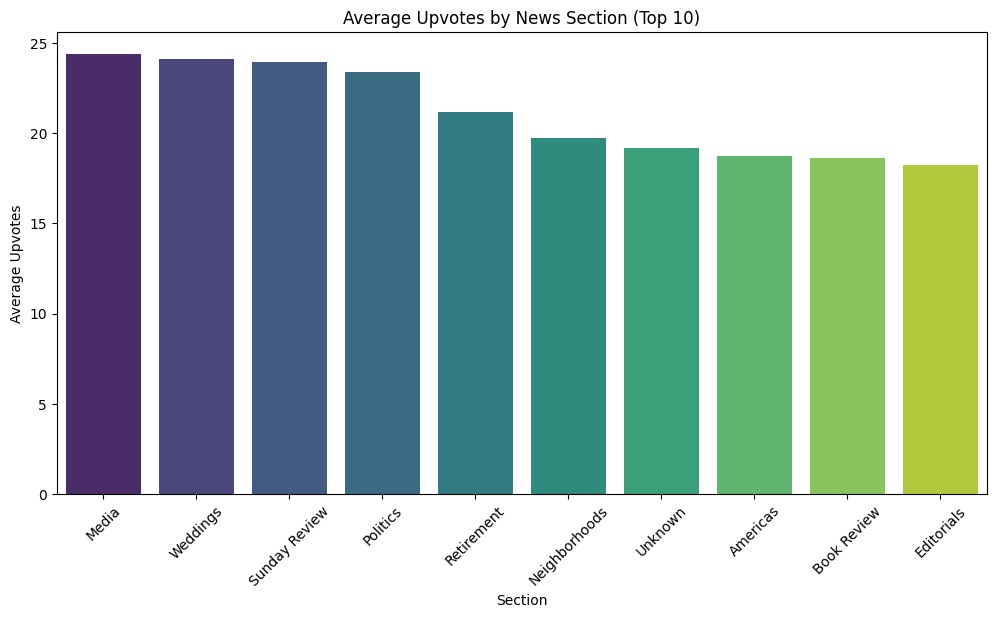

In [29]:
plt.figure(figsize=(12,6))

section_avg = (
    df.groupby("sectionName")["recommendations"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

sns.barplot(
    x=section_avg.index,
    y=section_avg.values,
    palette="viridis"
)

plt.xticks(rotation=45)
plt.title("Average Upvotes by News Section (Top 10)")
plt.xlabel("Section")
plt.ylabel("Average Upvotes")
plt.show()

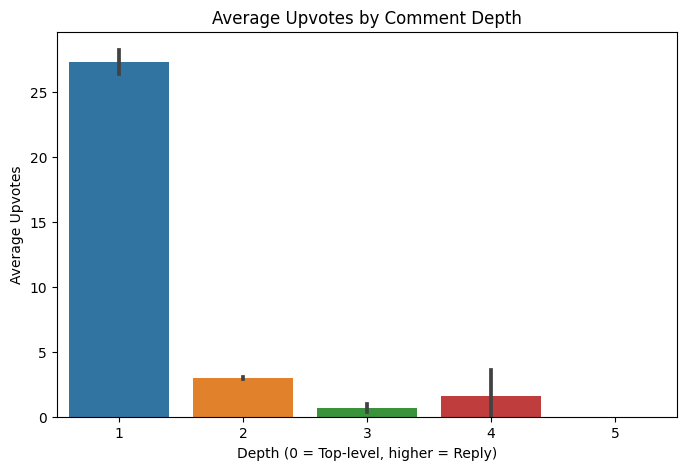

In [30]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="depth", 
    y="recommendations", 
    data=df.sample(100000, random_state=42)
)

plt.title("Average Upvotes by Comment Depth")
plt.xlabel("Depth (0 = Top-level, higher = Reply)")
plt.ylabel("Average Upvotes")
plt.show()

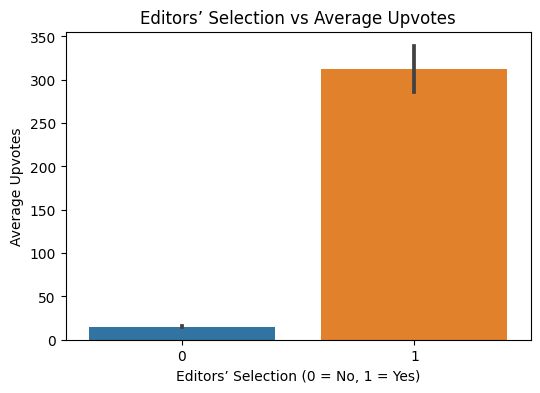

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="editorsSelection", 
    y="recommendations", 
    data=df.sample(100000, random_state=42)
)
plt.title("Editors’ Selection vs Average Upvotes")
plt.xlabel("Editors’ Selection (0 = No, 1 = Yes)")
plt.ylabel("Average Upvotes")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


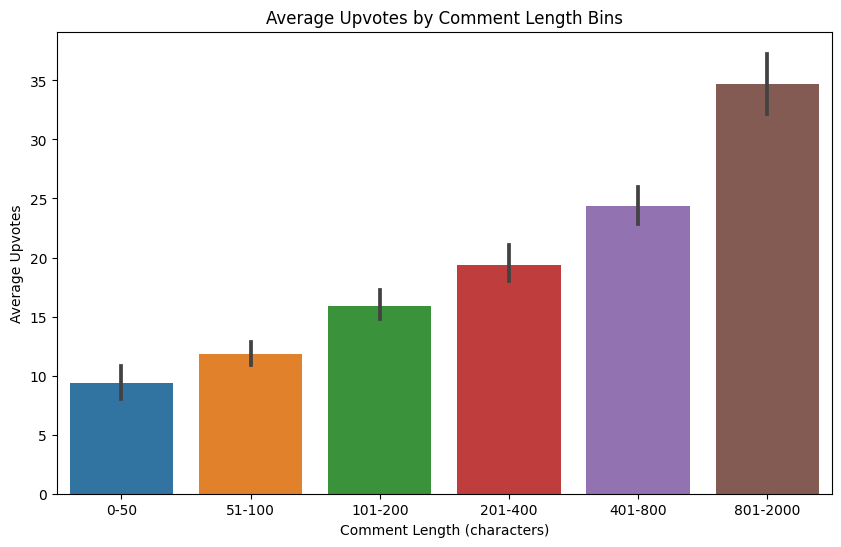

In [32]:
df_sample = df.sample(100000, random_state=42)

df_sample["comment_length"] = df_sample["commentBody"].fillna("").apply(len)

bins = [0, 50, 100, 200, 400, 800, 2000]
labels = ["0-50", "51-100", "101-200", "201-400", "401-800", "801-2000"]

df_sample["length_bin"] = pd.cut(df_sample["comment_length"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.barplot(
    x="length_bin", 
    y="recommendations", 
    data=df_sample,
    order=labels
)

plt.title("Average Upvotes by Comment Length Bins")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Average Upvotes")
plt.show()

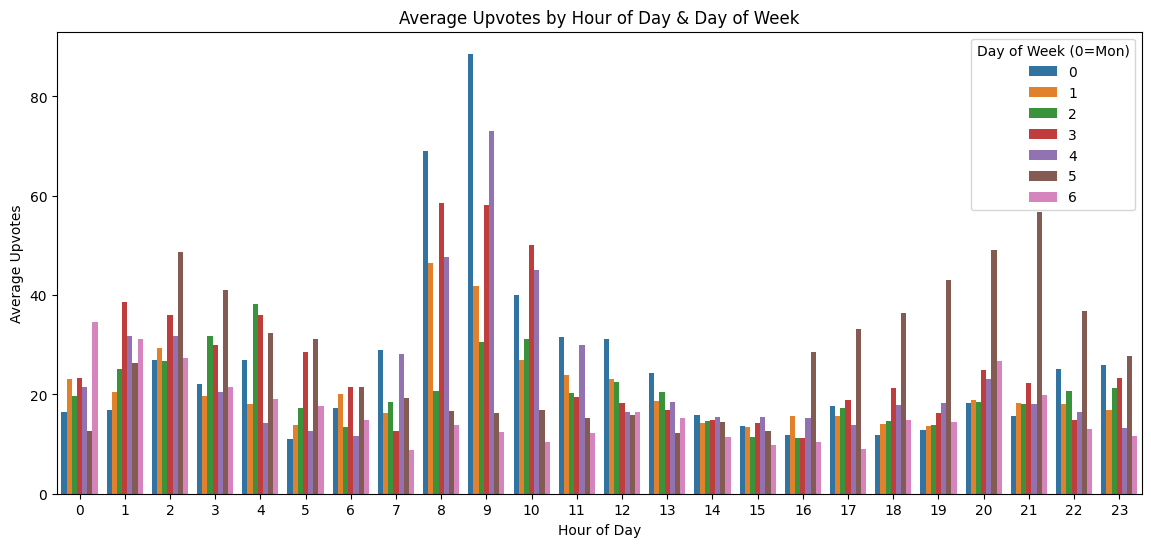

In [33]:
df_sample = df.sample(200000, random_state=42)

avg_upvotes = (
    df_sample.groupby(["dayofweek", "hour"])["recommendations"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.barplot(
    x="hour", 
    y="recommendations", 
    hue="dayofweek", 
    data=avg_upvotes,
    palette="tab10"
)

plt.title("Average Upvotes by Hour of Day & Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Average Upvotes")
plt.legend(title="Day of Week (0=Mon)")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


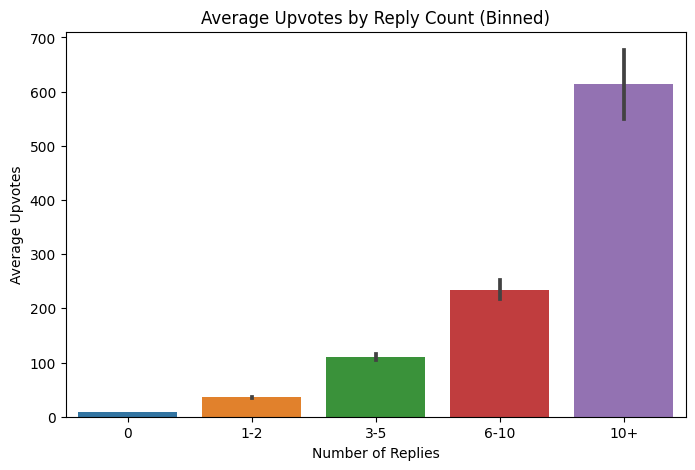

In [34]:
df_sample = df.sample(200000, random_state=42)

bins = [-1, 0, 2, 5, 10, 1000]  
labels = ["0", "1-2", "3-5", "6-10", "10+"]

df_sample["reply_bin"] = pd.cut(df_sample["replyCount"].fillna(0), bins=bins, labels=labels)

plt.figure(figsize=(8,5))
sns.barplot(
    x="reply_bin", 
    y="recommendations", 
    data=df_sample,
    order=labels
)

plt.title("Average Upvotes by Reply Count (Binned)")
plt.xlabel("Number of Replies")
plt.ylabel("Average Upvotes")
plt.show()

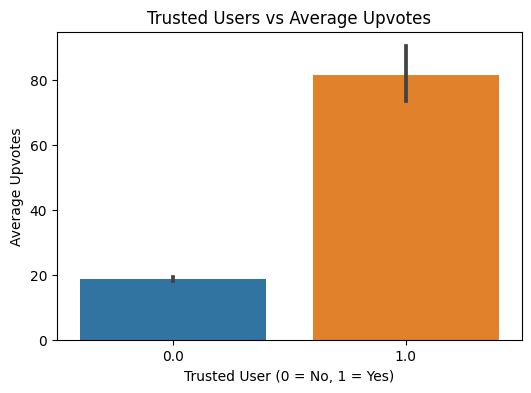

In [35]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="trusted", 
    y="recommendations", 
    data=df.sample(100000, random_state=42)
)
plt.title("Trusted Users vs Average Upvotes")
plt.xlabel("Trusted User (0 = No, 1 = Yes)")
plt.ylabel("Average Upvotes")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


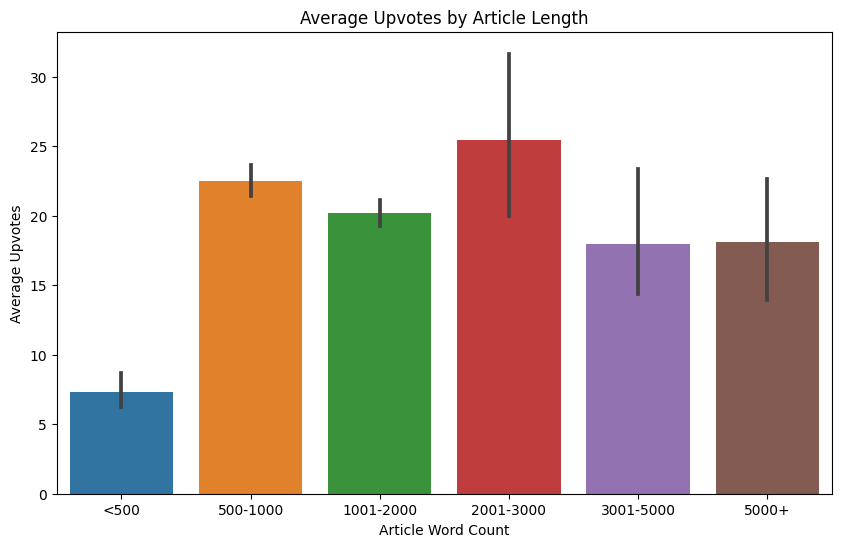

In [36]:
df_sample = df.sample(100000, random_state=42)
bins = [0, 500, 1000, 2000, 3000, 5000, 10000]
labels = ["<500", "500-1000", "1001-2000", "2001-3000", "3001-5000", "5000+"]

df_sample["article_length_bin"] = pd.cut(df_sample["articleWordCount"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.barplot(
    x="article_length_bin", 
    y="recommendations", 
    data=df_sample,
    order=labels
)
plt.title("Average Upvotes by Article Length")
plt.xlabel("Article Word Count")
plt.ylabel("Average Upvotes")
plt.show()

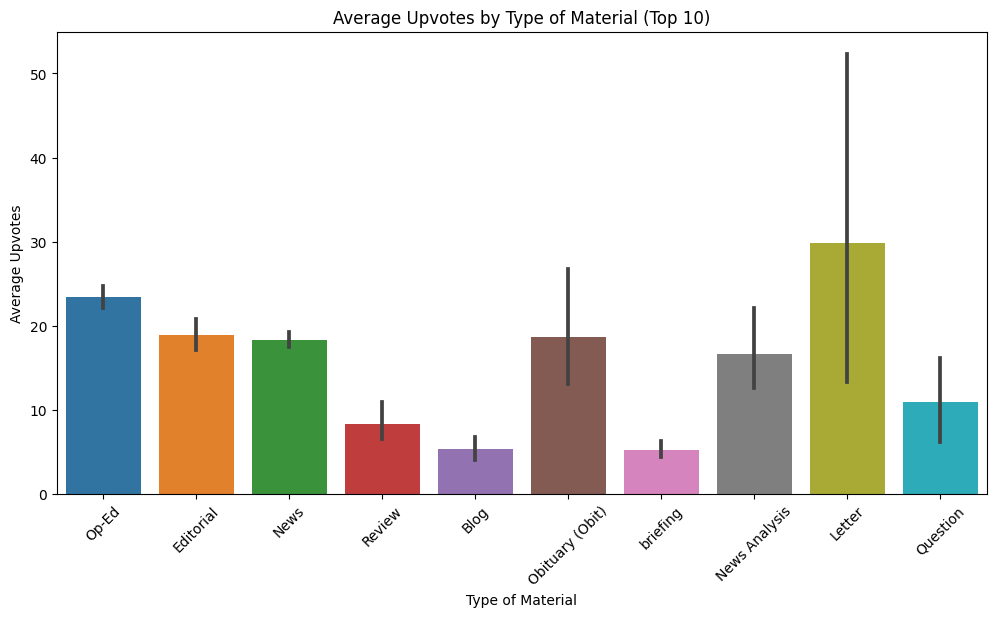

In [37]:
plt.figure(figsize=(12,6))
top_types = df['typeOfMaterial'].value_counts().index[:10]
sns.barplot(
    x="typeOfMaterial", 
    y="recommendations", 
    data=df[df['typeOfMaterial'].isin(top_types)].sample(100000, random_state=42)
)
plt.xticks(rotation=45)
plt.title("Average Upvotes by Type of Material (Top 10)")
plt.xlabel("Type of Material")
plt.ylabel("Average Upvotes")
plt.show()

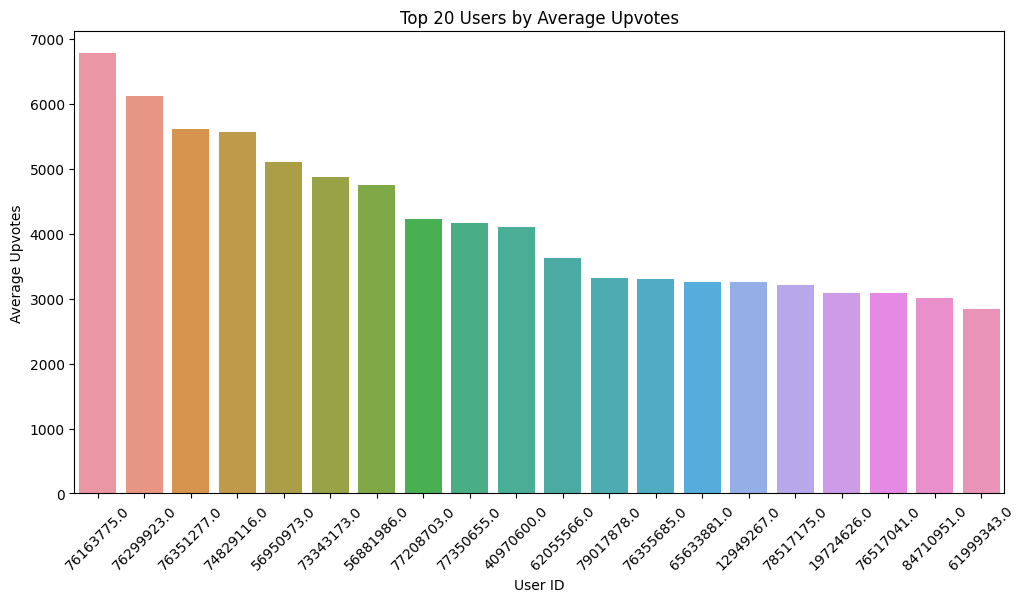

In [38]:
top_users = (
    df.groupby("userID")["recommendations"]
      .mean()
      .sort_values(ascending=False)
      .head(20)
)

plt.figure(figsize=(12,6))
sns.barplot(x=top_users.index.astype(str), y=top_users.values)
plt.xticks(rotation=45)
plt.title("Top 20 Users by Average Upvotes")
plt.xlabel("User ID")
plt.ylabel("Average Upvotes")
plt.show()

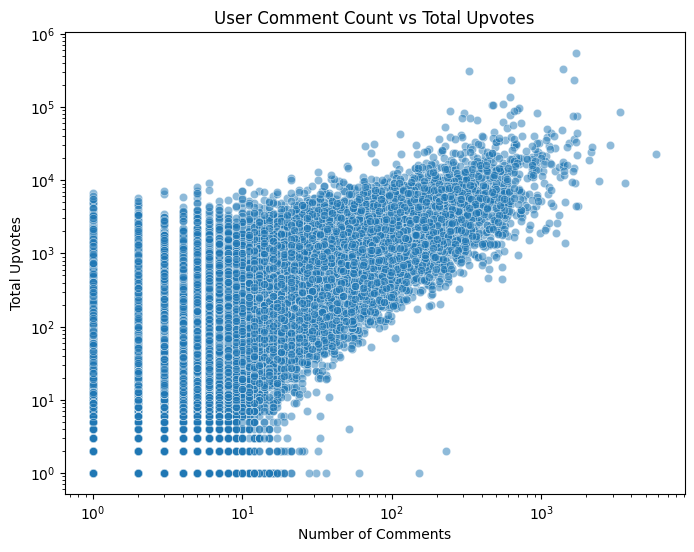

In [39]:
user_stats = df.groupby("userID").agg(
    total_upvotes=("recommendations", "sum"),
    comment_count=("commentID", "count")
).reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="comment_count", 
    y="total_upvotes", 
    data=user_stats, 
    alpha=0.5
)
plt.xscale("log")
plt.yscale("log")
plt.title("User Comment Count vs Total Upvotes")
plt.xlabel("Number of Comments")
plt.ylabel("Total Upvotes")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


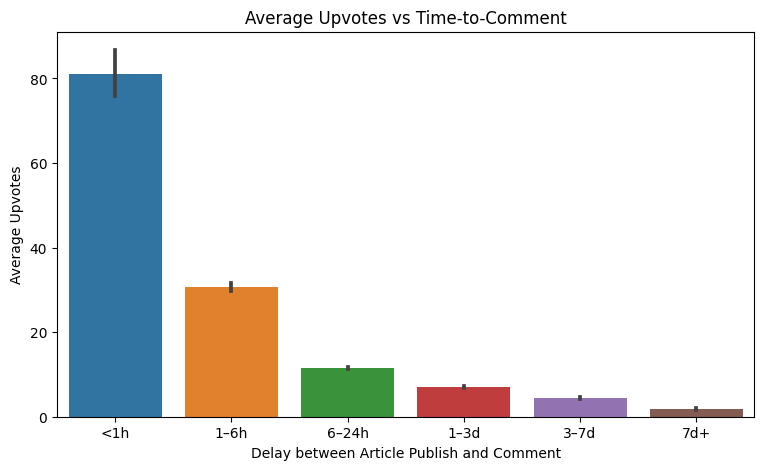

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


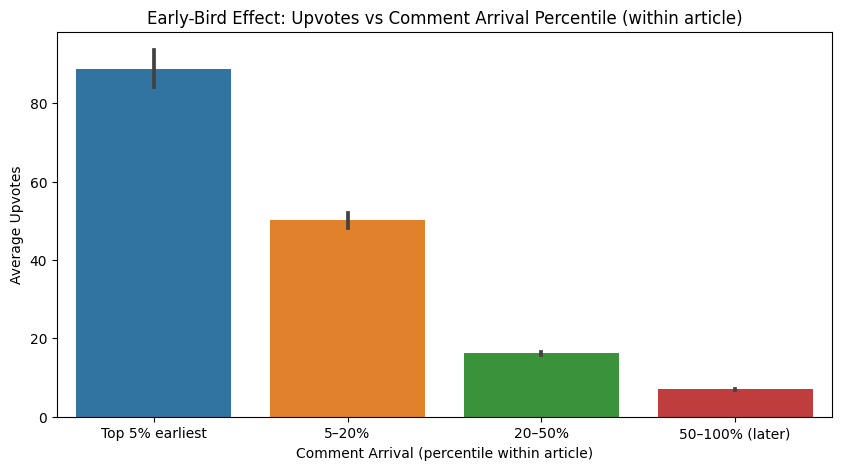

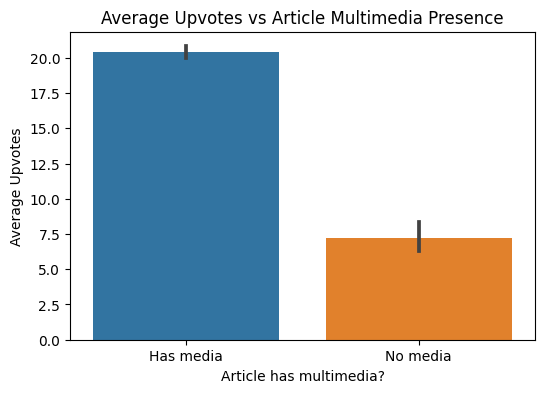

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


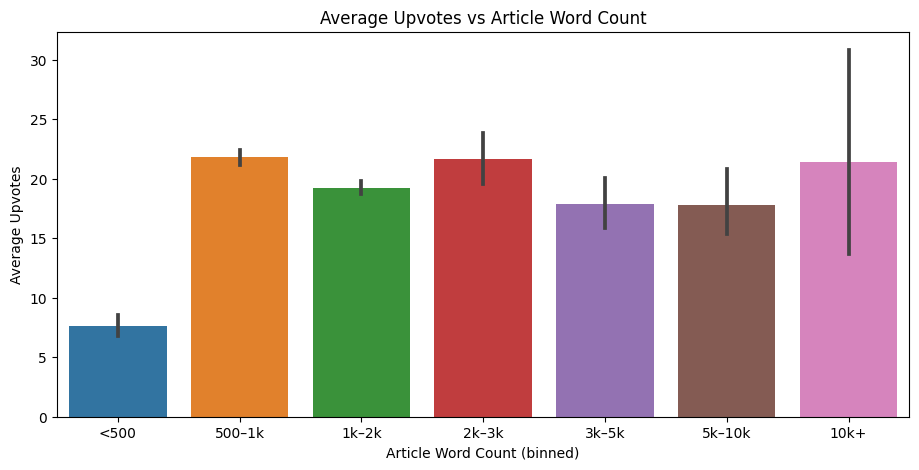

In [40]:
def build_comment_ts(df):
    # hour may have NaNs; set to 0 safely
    hrs = df["hour"].fillna(0).astype(int)
    return pd.to_datetime(
        dict(year=df["year"].astype(int),
             month=df["month"].astype(int),
             day=df["day"].astype(int),
             hour=hrs),
        errors="coerce"
    )

df_tt = df[["pubDate","year","month","day","hour","recommendations"]].copy()
df_tt["comment_ts"] = build_comment_ts(df_tt)

df_tt = df_tt.dropna(subset=["pubDate","comment_ts"])

delay_hours = (df_tt["comment_ts"] - df_tt["pubDate"]).dt.total_seconds() / 3600.0
df_tt["delay_hours"] = delay_hours

df_tt = df_tt[df_tt["delay_hours"] >= 0]

delay_bins = [-0.001, 1, 6, 24, 72, 168, np.inf]
delay_labels = ["<1h","1–6h","6–24h","1–3d","3–7d","7d+"]

df_tt["delay_bin"] = pd.cut(df_tt["delay_hours"], bins=delay_bins, labels=delay_labels)

plt.figure(figsize=(9,5))
sns.barplot(x="delay_bin", y="recommendations", data=df_tt.sample(min(300000, len(df_tt)), random_state=42), order=delay_labels)
plt.title("Average Upvotes vs Time-to-Comment")
plt.xlabel("Delay between Article Publish and Comment")
plt.ylabel("Average Upvotes")
plt.show()

need_cols = ["articleID","pubDate","year","month","day","hour","recommendations"]
df_rank = df[need_cols].dropna(subset=["articleID"]).copy()
df_rank["comment_ts"] = build_comment_ts(df_rank)

df_rank = df_rank.dropna(subset=["comment_ts","pubDate"])

df_rank = df_rank.sort_values(["articleID","comment_ts"])
grp = df_rank.groupby("articleID", observed=True)

df_rank["position"] = grp.cumcount() + 1
sizes = grp["recommendations"].transform("size")
df_rank["pos_pct"] = df_rank["position"] / sizes

pct_bins = [0, 0.05, 0.20, 0.50, 1.00]
pct_labels = ["Top 5% earliest","5–20%","20–50%","50–100% (later)"]
df_rank["arrival_bin"] = pd.cut(df_rank["pos_pct"], bins=pct_bins, labels=pct_labels, include_lowest=True)

plt.figure(figsize=(10,5))
sns.barplot(x="arrival_bin", y="recommendations", data=df_rank.sample(min(300000, len(df_rank)), random_state=43), order=pct_labels)
plt.title("Early-Bird Effect: Upvotes vs Comment Arrival Percentile (within article)")
plt.xlabel("Comment Arrival (percentile within article)")
plt.ylabel("Average Upvotes")
plt.show()

df_mm = df[["multimedia","recommendations"]].copy()
df_mm["has_media"] = (df_mm["multimedia"].fillna(0) > 0).map({False:"No media", True:"Has media"})

plt.figure(figsize=(6,4))
sns.barplot(x="has_media", y="recommendations", data=df_mm.sample(min(300000, len(df_mm)), random_state=44))
plt.title("Average Upvotes vs Article Multimedia Presence")
plt.xlabel("Article has multimedia?")
plt.ylabel("Average Upvotes")
plt.show()

df_depth = df[["depth","recommendations"]].copy()
df_depth["level"] = np.where(df_depth["depth"].fillna(0).astype(int) == 0, "Top-level", "Reply")

df_len = df[["articleWordCount","recommendations"]].copy()
bins = [0, 500, 1000, 2000, 3000, 5000, 10000, np.inf]
labels = ["<500","500–1k","1k–2k","2k–3k","3k–5k","5k–10k","10k+"]

df_len["article_len_bin"] = pd.cut(df_len["articleWordCount"].fillna(0), bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(11,5))
sns.barplot(x="article_len_bin", y="recommendations", data=df_len.sample(min(300000, len(df_len)), random_state=46), order=labels)
plt.title("Average Upvotes vs Article Word Count")
plt.xlabel("Article Word Count (binned)")
plt.ylabel("Average Upvotes")
plt.show()

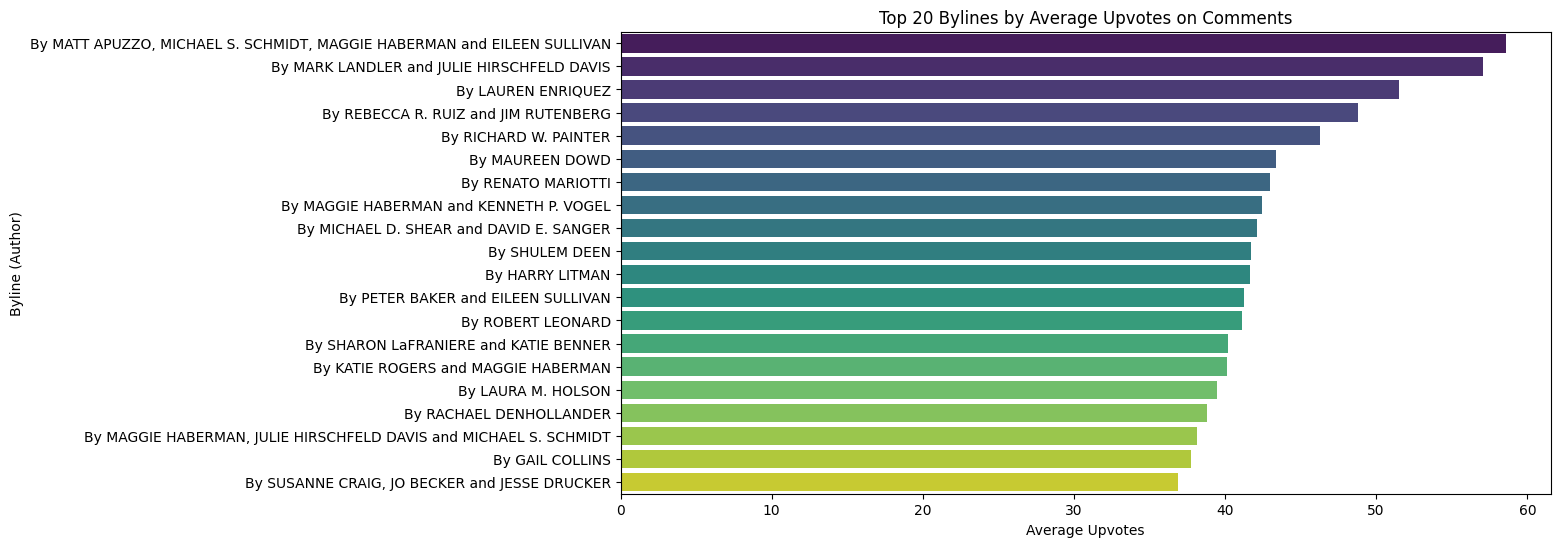

In [41]:
byline_stats = (
    df.groupby("byline")
      .agg(avg_upvotes=("recommendations","mean"),
           n_comments=("commentID","count"))
      .reset_index()
      .dropna(subset=["byline"])
)

byline_stats = byline_stats[byline_stats["n_comments"] >= 500]

top_bylines = byline_stats.sort_values("avg_upvotes", ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x="avg_upvotes", y="byline", data=top_bylines, palette="viridis")

plt.title("Top 20 Bylines by Average Upvotes on Comments")
plt.xlabel("Average Upvotes")
plt.ylabel("Byline (Author)")
plt.show()

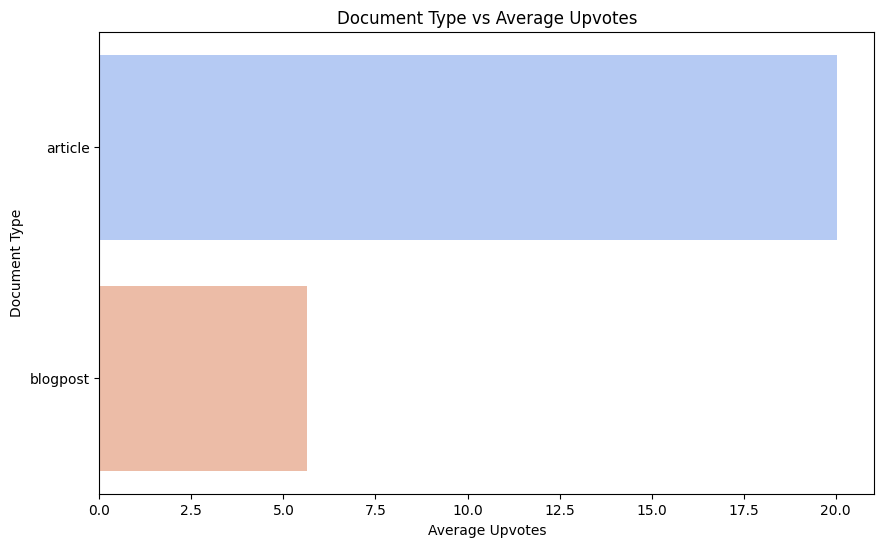

In [42]:
doc_stats = (
    df.groupby("documentType")
      .agg(avg_upvotes=("recommendations","mean"),
           n_comments=("commentID","count"))
      .reset_index()
      .dropna(subset=["documentType"])
)

doc_stats = doc_stats[doc_stats["n_comments"] >= 500]

doc_stats = doc_stats.sort_values("avg_upvotes", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_upvotes", y="documentType", data=doc_stats, palette="coolwarm")

plt.title("Document Type vs Average Upvotes")
plt.xlabel("Average Upvotes")
plt.ylabel("Document Type")
plt.show()

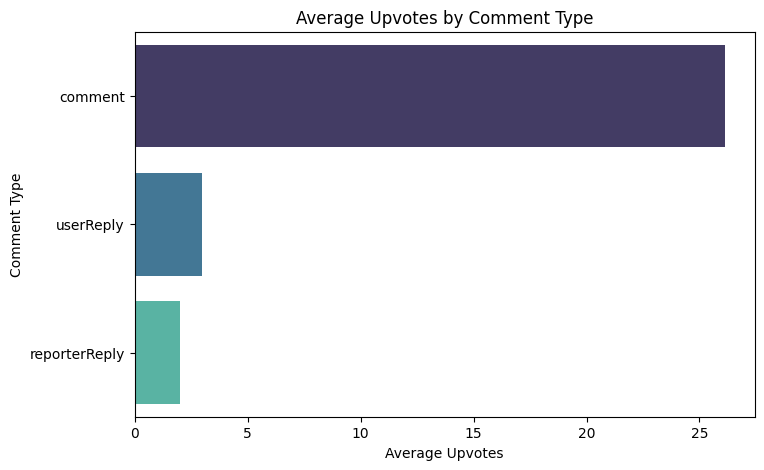

In [43]:
comment_type_stats = (
    df.groupby("commentType")["recommendations"]
      .mean()
      .reset_index()
      .dropna()
      .sort_values("recommendations", ascending=False)
)

plt.figure(figsize=(8,5))
sns.barplot(x="recommendations", y="commentType", data=comment_type_stats, palette="mako")

plt.title("Average Upvotes by Comment Type")
plt.xlabel("Average Upvotes")
plt.ylabel("Comment Type")
plt.show()

/tmp/ipykernel_37/1157922476.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("reply_bin")["recommendations"]
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


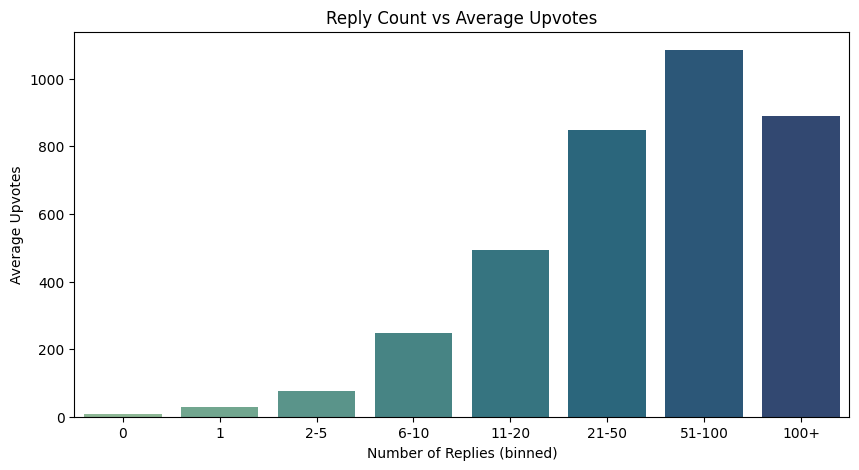

In [44]:
df["reply_bin"] = pd.cut(
    df["replyCount"],
    bins=[-1, 0, 1, 5, 10, 20, 50, 100, df["replyCount"].max()],
    labels=["0", "1", "2-5", "6-10", "11-20", "21-50", "51-100", "100+"]
)

reply_stats = (
    df.groupby("reply_bin")["recommendations"]
      .mean()
      .reset_index()
      .dropna()
)

plt.figure(figsize=(10,5))
sns.barplot(x="reply_bin", y="recommendations", data=reply_stats, palette="crest")

plt.title("Reply Count vs Average Upvotes")
plt.xlabel("Number of Replies (binned)")
plt.ylabel("Average Upvotes")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

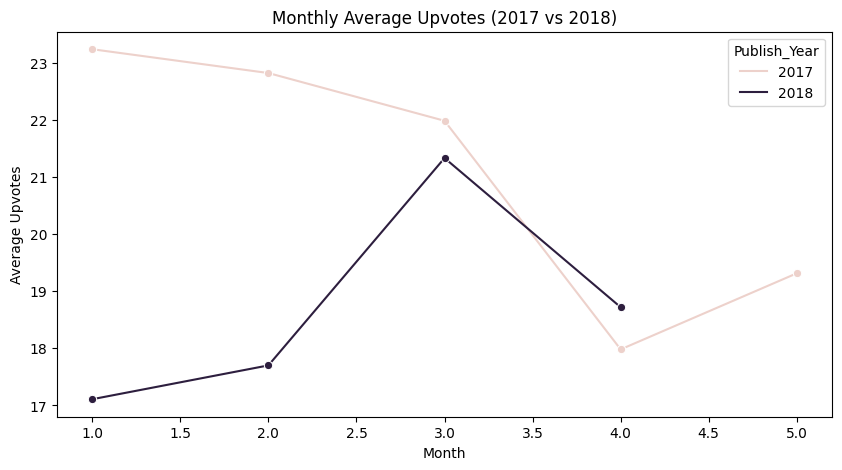

In [45]:
monthly_upvotes = (
    df.groupby(["Publish_Year", "Publish_Month"])["recommendations"]
      .mean()
      .reset_index()
)

monthly_upvotes = monthly_upvotes[
    ((monthly_upvotes["Publish_Year"] == 2017) & (monthly_upvotes["Publish_Month"].between(1,5))) |
    ((monthly_upvotes["Publish_Year"] == 2018) & (monthly_upvotes["Publish_Month"].between(1,4)))
]

plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_upvotes, 
    x="Publish_Month", 
    y="recommendations", 
    hue="Publish_Year", 
    marker="o"
)
plt.title("Monthly Average Upvotes (2017 vs 2018)")
plt.xlabel("Month")
plt.ylabel("Average Upvotes")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

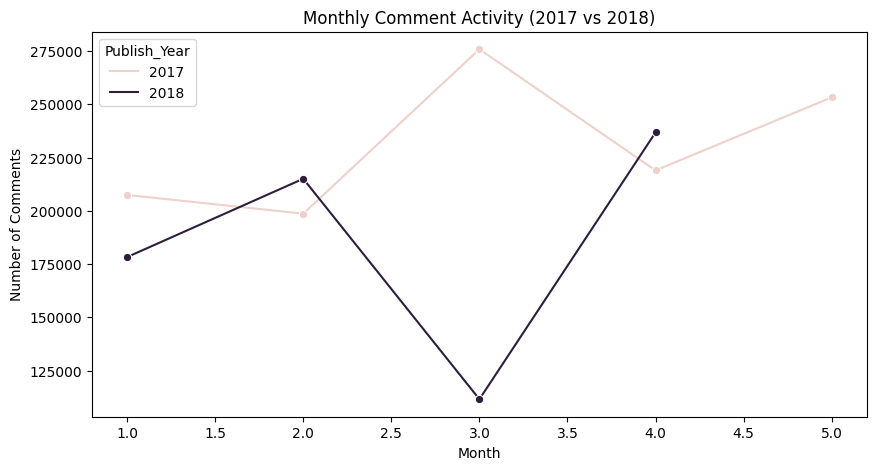

In [46]:
monthly_activity = (
    df.groupby(["Publish_Year", "Publish_Month"])["commentID"]
      .count()
      .reset_index()
      .rename(columns={"commentID": "num_comments"})
)

monthly_activity = monthly_activity[
    ((monthly_activity["Publish_Year"] == 2017) & (monthly_activity["Publish_Month"].between(1,5))) |
    ((monthly_activity["Publish_Year"] == 2018) & (monthly_activity["Publish_Month"].between(1,4)))
]

plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_activity, 
    x="Publish_Month", 
    y="num_comments", 
    hue="Publish_Year", 
    marker="o"
)
plt.title("Monthly Comment Activity (2017 vs 2018)")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.show()

In [18]:
rename_dict = {
   
    "articleID": "a_id",
    "byline": "a_byline",
    "documentType": "a_doc_type",
    "headline": "a_headline",
    "keywords": "a_keywords",
    "multimedia": "a_multimedia_count",
    "newDesk": "a_news_desk",
    "printPage": "a_print_page",
    "pubDate": "a_pub_date",
    "sectionName": "a_section",
    "snippet": "a_snippet",
    "typeOfMaterial": "a_material_type",
    "articleWordCount": "a_word_count",

    "commentBody": "c_body",
    "commentID": "c_id",
    "commentTitle": "c_title",
    "commentType": "c_type",
    "depth": "c_depth",
    "editorsSelection": "c_editors_selection",
    "inReplyTo": "c_in_reply_to",
    "parentID": "c_parent_id",

    "recommendations": "upvotes",   
    "replyCount": "c_reply_count",
    "sharing": "c_sharing",
    "timespeople": "c_timespeople",
    "trusted": "c_trusted",
    "userID": "u_id",

    "year": "c_year",
    "month": "c_month",
    "day": "c_day",
    "hour": "c_hour",
    "dayofweek": "c_dayofweek",
    "is_weekend": "c_is_weekend",

    "Publish_Day": "a_pub_day",
    "Publish_Month": "a_pub_month",
    "Publish_Year": "a_pub_year",
    "Publish_Dayofweek": "a_pub_dayofweek",
    "Publish_IsWeekend": "a_pub_is_weekend",

    "reply_bin": "c_reply_bin"
}

df = df.rename(columns=rename_dict)

print("Columns after renaming:\n")
print(df.columns)

Columns after renaming:

Index(['a_id', 'a_byline', 'a_doc_type', 'a_headline', 'a_keywords',
       'a_multimedia_count', 'a_news_desk', 'a_print_page', 'a_pub_date',
       'a_section', 'a_snippet', 'a_material_type', 'a_word_count', 'c_body',
       'c_id', 'c_title', 'c_type', 'c_depth', 'c_editors_selection',
       'c_in_reply_to', 'c_parent_id', 'upvotes', 'c_reply_count', 'c_sharing',
       'c_timespeople', 'c_trusted', 'u_id', 'c_year', 'c_month', 'c_day',
       'c_hour', 'c_dayofweek', 'c_is_weekend', 'a_pub_day', 'a_pub_month',
       'a_pub_year', 'a_pub_dayofweek', 'a_pub_is_weekend'],
      dtype='object')


In [48]:
ordered_cols = [

    "a_id", "a_headline", "a_byline", "a_doc_type", "a_section",
    "a_keywords", "a_material_type", "a_snippet",
    "a_multimedia_count", "a_news_desk", "a_print_page",
    "a_word_count", "a_pub_date",
    "a_pub_year", "a_pub_month", "a_pub_day",
    "a_pub_dayofweek", "a_pub_is_weekend",
    

    "c_id", "c_body", "c_title", "c_type",
    "c_depth", "c_editors_selection", "c_in_reply_to", "c_parent_id",
    "c_reply_count", "c_sharing", "c_timespeople", "c_trusted",
    "c_year", "c_month", "c_day", "c_hour",
    "c_dayofweek", "c_is_weekend", "c_reply_bin",
    
    "u_id",
    
    "upvotes"
]

df = df[ordered_cols]

print("Final structure:")
print(df.columns.tolist())

Final structure:
['a_id', 'a_headline', 'a_byline', 'a_doc_type', 'a_section', 'a_keywords', 'a_material_type', 'a_snippet', 'a_multimedia_count', 'a_news_desk', 'a_print_page', 'a_word_count', 'a_pub_date', 'a_pub_year', 'a_pub_month', 'a_pub_day', 'a_pub_dayofweek', 'a_pub_is_weekend', 'c_id', 'c_body', 'c_title', 'c_type', 'c_depth', 'c_editors_selection', 'c_in_reply_to', 'c_parent_id', 'c_reply_count', 'c_sharing', 'c_timespeople', 'c_trusted', 'c_year', 'c_month', 'c_day', 'c_hour', 'c_dayofweek', 'c_is_weekend', 'c_reply_bin', 'u_id', 'upvotes']


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913721 entries, 0 to 1991145
Data columns (total 39 columns):
 #   Column               Dtype         
---  ------               -----         
 0   a_id                 object        
 1   a_headline           object        
 2   a_byline             object        
 3   a_doc_type           object        
 4   a_section            object        
 5   a_keywords           object        
 6   a_material_type      object        
 7   a_snippet            object        
 8   a_multimedia_count   int64         
 9   a_news_desk          object        
 10  a_print_page         int64         
 11  a_word_count         int64         
 12  a_pub_date           datetime64[ns]
 13  a_pub_year           int32         
 14  a_pub_month          int32         
 15  a_pub_day            int32         
 16  a_pub_dayofweek      int32         
 17  a_pub_is_weekend     bool          
 18  c_id                 float64       
 19  c_body               objec

In [50]:
df.columns

Index(['a_id', 'a_headline', 'a_byline', 'a_doc_type', 'a_section',
       'a_keywords', 'a_material_type', 'a_snippet', 'a_multimedia_count',
       'a_news_desk', 'a_print_page', 'a_word_count', 'a_pub_date',
       'a_pub_year', 'a_pub_month', 'a_pub_day', 'a_pub_dayofweek',
       'a_pub_is_weekend', 'c_id', 'c_body', 'c_title', 'c_type', 'c_depth',
       'c_editors_selection', 'c_in_reply_to', 'c_parent_id', 'c_reply_count',
       'c_sharing', 'c_timespeople', 'c_trusted', 'c_year', 'c_month', 'c_day',
       'c_hour', 'c_dayofweek', 'c_is_weekend', 'c_reply_bin', 'u_id',
       'upvotes'],
      dtype='object')

In [51]:
df.drop(columns = ["a_pub_date","a_doc_type" , "c_reply_bin"], axis =1 , inplace = True)

In [52]:
df["a_byline"].unique()

array(['By JENNIFER STEINHAUER', 'By MARK LANDLER', 'By CAITLIN LOVINGER',
       ..., 'By BRIAN GATENS', 'By BARBARA BOLTON',
       'By HIROKO TABUCHI and HENRY FOUNTAIN'], dtype=object)

In [53]:
by_starts = df['a_byline'].str.strip().str.lower().str.startswith('by')

print(by_starts.value_counts())

print(df.loc[~by_starts, 'a_byline'].sample(50))

a_byline
True     1908052
False       5669
Name: count, dtype: int64
1918856                                          FRANK BRUNI
393649                             Compiled by LARA TAKENAGA
1564033                                      CHARLES M. BLOW
394091                             Compiled by LARA TAKENAGA
135224                                           FRANK BRUNI
1419448    Text by RON NIXON and PHOTOGRAPHS BY TODD HEISLER
1314861                           Interview by ANA MARIE COX
134655                                           FRANK BRUNI
1563343                                      CHARLES M. BLOW
1032054                           Interview by ANA MARIE COX
1596457                            Compiled by INSIDER STAFF
1214596                                 Text by ILIANA MAGRA
1622143                                 Text by ILIANA MAGRA
1563822                                      CHARLES M. BLOW
1214532                                 Text by ILIANA MAGRA
134886          

In [54]:
def extract_authors_simple(name):
    if pd.isnull(name):
        return ''
    name = name.strip()
    parts = re.split(r'\bby\b', name, flags=re.IGNORECASE)
    
    authors = []
    for part in parts[1:]: 
        cleaned = re.sub(r'\b(text|photographs|compiled|introduction|interview)\b', '', part, flags=re.IGNORECASE)
        sub_authors = [a.strip() for a in re.split(r'\band\b', cleaned, flags=re.IGNORECASE) if a.strip()]
        authors.extend(sub_authors)
    
    return ' and '.join(authors)

df['a_byline'] = df['a_byline'].apply(extract_authors_simple)

print((df['a_byline']).sample(70))

1270132                         JAMES DOBBINS
3649                      THE EDITORIAL BOARD
1150720                         JIM RUTENBERG
467981                          QUOCTRUNG BUI
1092554       PETER BAKER and STEVEN ERLANGER
                          ...                
1018315                   THE EDITORIAL BOARD
1042199    MAGGIE HABERMAN and CHARLIE SAVAGE
1150942                         JIM RUTENBERG
1568533    BENEDICT CAREY and ROBERT GEBELOFF
1807193     MATTHEW ROSENBERG and MATT APUZZO
Name: a_byline, Length: 70, dtype: object


In [55]:
df["c_body"].unique()

array(['For all you Americans out there --- still rejoicing over the majority win of  Republicans over the Legislature of this land.<br/>Beware.<br/>Just like you would have been, if  there were any other kind of majority.<br/>The Founding Fathers had something like this in mind wheh they formed our Great Nation.<br/>It\'s part of the natural \'Checks &amp; Balances\' system that keeps this country on an even keel.<br/>But this is now being threatened -- with the majority of Executive, Legislative and Judidical power all in the hands of one political party.<br/>See to it that you remember our U.S. Constitution, and our Bill of Rights.<br/>Remember that "We", are still "the People".<br/>America belongs to all of us.<br/>And God help us all.',
       'Obamas policies may prove to be the least of this countrys worries.  The GOP has been emboldened to actually cut the OCE in the night before the new president or congress is sworn in following in their leaders footsteps.  Everyone is crying

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913721 entries, 0 to 1991145
Data columns (total 36 columns):
 #   Column               Dtype  
---  ------               -----  
 0   a_id                 object 
 1   a_headline           object 
 2   a_byline             object 
 3   a_section            object 
 4   a_keywords           object 
 5   a_material_type      object 
 6   a_snippet            object 
 7   a_multimedia_count   int64  
 8   a_news_desk          object 
 9   a_print_page         int64  
 10  a_word_count         int64  
 11  a_pub_year           int32  
 12  a_pub_month          int32  
 13  a_pub_day            int32  
 14  a_pub_dayofweek      int32  
 15  a_pub_is_weekend     bool   
 16  c_id                 float64
 17  c_body               object 
 18  c_title              object 
 19  c_type               object 
 20  c_depth              int32  
 21  c_editors_selection  int64  
 22  c_in_reply_to        float64
 23  c_parent_id          float64
 24  c_r

In [57]:
df['a_section'].unique()

array(['Politics', 'Asia Pacific', 'Unknown', 'Pro Basketball',
       'Television', 'Baseball', 'Europe', 'Mind', 'Move', 'Family',
       'Media', 'Soccer', 'Sunday Review', 'Americas', 'Pro Football',
       'College Football', 'Live', 'Eat', 'Lesson Plans', 'Economy',
       'Room For Debate', 'Tennis', 'Book Review', 'DealBook',
       'Middle East', 'Africa', 'Canada', 'College Basketball',
       'Education Life', 'The Daily', 'Editorials', 'Art & Design',
       'Energy & Environment ', 'Music', 'Wine, Beer & Cocktails',
       'Olympics', 'Personal Tech', 'Fashion & Beauty', 'Dance', 'Hockey',
       'Golf', 'Retirement', "401(k)'s and Similar Plans",
       'Entrepreneurship', 'Entertainment', 'Opinion | Politics',
       'Weddings', 'Real Estate', 'Australia', 'Neighborhoods', 'Rugby',
       'Paying for College', 'Insider Events', 'Automobiles', 'Food',
       'Art', 'Opinion | The World', 'Student Loans', 'Auto Racing',
       'Cycling', 'Learning', 'Cricket'], dtype=objec

In [58]:
df['a_news_desk'].unique()

array(['National', 'Foreign', 'Games', 'OpEd', 'Metro', 'Sports',
       'Culture', 'Editorial', 'Science', 'Upshot', 'Learning', 'Unknown',
       'Magazine', 'Business', 'SundayBusiness', 'RealEstate', 'Well',
       'Dining', 'Styles', 'Insider', 'Weekend', 'BookReview', 'Travel',
       'Metropolitan', 'Politics', 'EdLife', 'Letters', 'Podcasts',
       'Washington', 'Smarter Living', 'Climate', 'NewsDesk', 'Obits',
       'Arts&Leisure', 'Express', 'Video', 'TStyle', 'SpecialSections',
       'Photo', 'Investigative', 'Society', 'Summary', 'NYTNow',
       'Automobiles'], dtype=object)

In [59]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)           # remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

text_columns = ['a_headline', 'a_snippet', 'a_keywords', 'c_title', 'c_body']
for col in text_columns:
    df[col+'_clean'] = df[col].apply(clean_text)

In [61]:
df["c_type"].nunique()

3

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1913721 entries, 0 to 1991145
Data columns (total 41 columns):
 #   Column               Dtype  
---  ------               -----  
 0   a_id                 object 
 1   a_headline           object 
 2   a_byline             object 
 3   a_section            object 
 4   a_keywords           object 
 5   a_material_type      object 
 6   a_snippet            object 
 7   a_multimedia_count   int64  
 8   a_news_desk          object 
 9   a_print_page         int64  
 10  a_word_count         int64  
 11  a_pub_year           int32  
 12  a_pub_month          int32  
 13  a_pub_day            int32  
 14  a_pub_dayofweek      int32  
 15  a_pub_is_weekend     bool   
 16  c_id                 float64
 17  c_body               object 
 18  c_title              object 
 19  c_type               object 
 20  c_depth              int32  
 21  c_editors_selection  int64  
 22  c_in_reply_to        float64
 23  c_parent_id          float64
 24  c_r

In [63]:
df['a_byline'].nunique()

2680

In [16]:
from transformers import DistilBertTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
from tqdm import tqdm

MODEL_PATH = "/kaggle/input/distilbertbaseuncasedfinetunedsst2english/distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_PATH, from_pt=False, local_files_only=True)

# Example sentiment function with tqdm
def get_sentiment_scores(texts, batch_size=32):
    texts = [str(t) if t is not None else "" for t in texts]
    scores = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=512, return_tensors="tf")
        outputs = model(encodings)
        logits = outputs.logits.numpy()
        
        # Softmax to probabilities
        probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

        # Map probabilities to sentiment scores
        for prob in probs:
            pos_score = prob[1]
            neg_score = prob[0]
            if pos_score > neg_score:
                scores.append(pos_score)
            elif pos_score == neg_score:
                scores.append(0.0)
            else:
                scores.append(-neg_score)
    return np.array(scores)

Some layers from the model checkpoint at /kaggle/input/distilbertbaseuncasedfinetunedsst2english/distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distilbertbaseuncasedfinetunedsst2english/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should 

In [65]:
articles = df[['a_id','a_headline','a_snippet','a_keywords']].drop_duplicates('a_id')

for col in ['a_headline','a_snippet','a_keywords']:
    print(f"Processing unique {col}")
    articles[col+'_sentiment'] = get_sentiment_scores(articles[col].fillna("").tolist(), batch_size=64)

Processing unique a_headline


Processing batches: 100%|██████████| 131/131 [00:14<00:00,  8.98it/s]


Processing unique a_snippet


Processing batches: 100%|██████████| 131/131 [00:17<00:00,  7.55it/s]


Processing unique a_keywords


Processing batches: 100%|██████████| 131/131 [00:32<00:00,  3.98it/s]


In [66]:
df = df.merge(articles[['a_id','a_headline_sentiment','a_snippet_sentiment','a_keywords_sentiment']],
              on='a_id', how='left')

In [67]:
col = 'c_title' 
print(f"\nProcessing column: {col}")
sentiment_scores = get_sentiment_scores(df[col].fillna("").tolist(), batch_size=64)

temp = pd.DataFrame({
    'row_id': df.index,
    col + '_sentiment': sentiment_scores
})
temp.to_parquet(f'{col}_sentiment.parquet', index=False)


Processing column: c_title


Processing batches: 100%|██████████| 29902/29902 [56:50<00:00,  8.77it/s]


In [ ]:
col = 'c_title' 
print(f"\nProcessing column: c_body")
sentiment_scores = get_sentiment_scores(df[col].fillna("").tolist(), batch_size=64)

temp = pd.DataFrame({
    'row_id': df.index,
    col + '_sentiment': sentiment_scores
})


Processing column: c_body


Processing batches:  23%|██▎       | 6976/29902 [12:09<40:56,  9.33it/s]

In [ ]:
col = 'c_body'  
print(f"\nProcessing column: {col}")
sentiment_scores = get_sentiment_scores(df[col].fillna("").tolist(), batch_size=64)

temp = pd.DataFrame({
    'row_id': df.index,
    col + '_sentiment': sentiment_scores
})
temp.to_parquet(f'{col}_sentiment.parquet', index=False)

In [73]:
df_new = df.copy()
for col in ['c_title','c_body']:
    temp = pd.read_parquet(f'/kaggle/input/comments/{col}_sentiment.parquet')
    df_new = df_new.merge(temp, left_index=True, right_on='row_id', how='left')
    df_new = df_new.drop(columns=['row_id'])

In [75]:
df_new.drop(columns = ["a_id", "a_headline", "a_keywords", "a_snippet", "c_body", "c_title", 
                       "a_headline_clean", "a_snippet_clean", "a_keywords_clean", 
                       "c_body_clean", "c_title_clean"], axis =1, inplace = True)

In [77]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913721 entries, 0 to 1913720
Data columns (total 35 columns):
 #   Column                Dtype  
---  ------                -----  
 0   a_byline              object 
 1   a_section             object 
 2   a_material_type       object 
 3   a_multimedia_count    int64  
 4   a_news_desk           object 
 5   a_print_page          int64  
 6   a_word_count          int64  
 7   a_pub_year            int32  
 8   a_pub_month           int32  
 9   a_pub_day             int32  
 10  a_pub_dayofweek       int32  
 11  a_pub_is_weekend      bool   
 12  c_id                  float64
 13  c_type                object 
 14  c_depth               int32  
 15  c_editors_selection   int64  
 16  c_in_reply_to         float64
 17  c_parent_id           float64
 18  c_reply_count         float64
 19  c_sharing             int64  
 20  c_timespeople         float64
 21  c_trusted             float64
 22  c_year                int32  
 23  c_month

In [82]:
df_new.to_csv("df_new.csv")